# Evaluation of classifiers for ACM ASIACC paper

128-feature vector

## Loading data and selecting features of interest

In [1]:
import pyarrow as pa
import pyarrow.parquet as pq

#phishing = pq.read_table('floor/phishing_2307.parquet')
phishing = pq.read_table('floor/phishing_2311.parquet')
benign = pq.read_table('floor/benign_2310.parquet')

from transformers.drop_nontrain import drop_nontrain_table as drop_nontrain
phishing = drop_nontrain(phishing)
benign = drop_nontrain(benign)

# realign schemas (parquet files save in nonsense orders)
benign = benign.cast(phishing.schema)

# concatentate tables
data = pa.concat_tables([phishing, benign])
df = data.to_pandas()

print(f"Total records: {len(df)}")

from transformers.cast_timestamp import cast_timestamp
df = cast_timestamp(df)

used_features = [

    # IP  ===============================
    # Used in the original NOMS paper
    "ip_mean_average_rtt",
    "ip_entropy",
    "ip_count",
    #"ip_v4_count", "ip_v6_count", # Moved RDAP and RENAMED to rdap_ip
    
    # Newly added for ACM ASIACCS
    "ip_v4_ratio",
    #"ip_a_aaaa_to_all_ratio", <--- not useful for this dataset
    "ip_as_address_entropy",
    "ip_asn_entropy",
    "ip_distinct_as_count",
    
    # DNS  ===============================
    # Used in the original NOMS paper
    "dns_A_count",
    "dns_AAAA_count",
    "dns_MX_count",
    "dns_NS_count",
    #"dns_SOA_count", <-- REMOVED, very low effect -------------------------------------
    "dns_TXT_count",
    "dns_CNAME_count",
    "dns_soa_primary_ns_len",
    "dns_soa_primary_ns_level", # renamed
    "dns_soa_primary_ns_digit_count",
    "dns_soa_primary_ns_entropy",
    "dns_soa_email_len",
    "dns_soa_email_level", # renamed
    "dns_soa_email_digit_count",
    "dns_soa_email_entropy",
    # "dns_soa_serial", <-- Doesn't convey any kind of comparative information
    "dns_soa_refresh",
    "dns_soa_retry",
    "dns_soa_expire",
    "dns_mx_avg_len",
    "dns_mx_avg_entropy",
    "dns_domain_name_in_mx",
    "dns_txt_spf_exists",
    "dns_txt_avg_entropy",
    "dns_txt_dkim_exists",
    
    "dns_zone_level",
    "dns_zone_digit_count",
    "dns_zone_len",
    "dns_zone_entropy",
    
    # Newly added for ACM ASIACCS
    "dns_resolved_record_types",
    "dns_has_dnskey",
    "dns_dnssec_score",
    "dns_ttl_avg",
    "dns_ttl_stdev",
    "dns_ttl_low",
    "dns_ttl_mid",
    "dns_ttl_distinct_count",
    "dns_soa_min_ttl", # why is this not in NOMS?!
    "dns_txt_external_verification_score",
    "dns_txt_dmarc_exists",
    
    
    # TLS  ===============================
    # Used in the original NOMS paper
    "tls_broken_chain",
    "tls_expired_chain",
    "tls_is_self_signed", # <--- NEW (23-12-02)
    "tls_root_authority_hash", # <--- NEW (23-12-02)
    "tls_leaf_authority_hash", # <--- NEW (23-12-02)
    "tls_total_extension_count",
    "tls_critical_extensions",
    "tls_with_policies_crt_count",
    "tls_percentage_crt_with_policies",
    "tls_x509_anypolicy_crt_count",
    "tls_iso_policy_crt_count",
    "tls_joint_isoitu_policy_crt_count",
    # "tls_iso_policy_oid", <-- Basically a random value, doesn't make much sense when collected like this; policy OIDs need more research
    # "tls_isoitu_policy_oid", <-- same
    #"tls_unknown_policy_crt_count", <-- Abandoned, no useful values
    "tls_root_cert_validity_len",
    "tls_leaf_cert_validity_len",
    "tls_chain_len",
    #"tls_root_cert_lifetime", <---- NO!
    #"tls_leaf_cert_lifetime", <---- NO!
    "tls_subject_count",
    "tls_unique_SLD_count",
    "tls_server_auth_crt_count",
    "tls_client_auth_crt_count",
    "tls_CA_certs_in_chain_ratio",
    "tls_common_name_count",
    
    # Newly added for ACM ASIACCS
    #"tls_has_tls", , <-- REMOVED, very low effect -------------------------------------
    "tls_negotiated_version_id",
    "tls_negotiated_cipher_id",
    
    # LEX ===============================
    # Used in the original NOMS paper
    "lex_name_len",
    #"lex_digit_count", <-- abandoned, almost the same as "lex_sub_digit_ratio"
    "lex_has_digit",
    "lex_phishing_keyword_count",
    #"lex_vowel_count", <-- moved to sub
    #"lex_underscore_hyphen_count", <--- same as nonalnum
    "lex_consecutive_chars",
    "lex_tld_len",
    "lex_tld_abuse_score", # *************************************************************
    "lex_tld_hash", # *************************************************************
    
    "lex_sld_len",
    "lex_sld_norm_entropy", # <-- newly added feature on 23-09-29
    # ============================= New SLD features 23-11
    "lex_sld_phishing_keyword_count",
    #"lex_sld_digit_count",
    #"lex_sld_digit_ratio",
    "lex_sld_vowel_count",
    "lex_sld_vowel_ratio",
    "lex_sld_consonant_count",
    "lex_sld_consonant_ratio",
    "lex_sld_non_alphanum_count",
    "lex_sld_non_alphanum_ratio",
    "lex_sld_hex_count",
    "lex_sld_hex_ratio",
    # =============================      
    
    "lex_sub_count",
    "lex_stld_unique_char_count",
    "lex_begins_with_digit",
    "lex_www_flag",
    "lex_sub_max_consonant_len",
    "lex_sub_norm_entropy",
    "lex_sub_digit_count",
    "lex_sub_digit_ratio",
    "lex_sub_consonant_ratio",
    "lex_sub_non_alphanum_ratio",
    "lex_sub_hex_ratio",

    #"lex_bigram_matches",  # OLD NAME
    #"lex_trigram_matches", # OLD NAME
    "lex_phishing_bigram_matches",  # NEW NAME
    "lex_phishing_trigram_matches", # NEW NAME
    "lex_phishing_tetragram_matches", # *************************************************************
    "lex_phishing_pentagram_matches", # *************************************************************
    "lex_sub_vowel_count",
    "lex_sub_vowel_ratio",
    "lex_sub_consonant_count",
    "lex_sub_non_alphanum_count",
    "lex_sub_hex_count",
    "lex_avg_part_len",
    "lex_stdev_part_lens",
    "lex_longest_part_len",
    "lex_shortest_sub_len",
    
    # RDAP ===============================
    # Used in the original NOMS paper
    "rdap_registration_period",
    "rdap_domain_age",
    "rdap_time_from_last_change",
    "rdap_domain_active_time",
    "rdap_has_dnssec",
    "rdap_ip_v4_count", "rdap_ip_v6_count", # <-- used for NOMS, but now prefixed with rdap_
    
    # Newly added for ACM ASIACCS
    "rdap_registrar_name_len",
    "rdap_registrar_name_entropy",
    "rdap_registrar_name_hash",
    "rdap_registrant_name_len",
    "rdap_registrant_name_entropy",
    "rdap_admin_name_len",
    "rdap_admin_name_entropy",
    "rdap_admin_email_len",
    "rdap_admin_email_entropy",
    
    "rdap_ip_shortest_v4_prefix_len",
    "rdap_ip_longest_v4_prefix_len",
    "rdap_ip_shortest_v6_prefix_len",
    "rdap_ip_longest_v6_prefix_len",
    
    "rdap_ip_avg_admin_name_len",
    "rdap_ip_avg_admin_name_entropy",
    "rdap_ip_avg_admin_email_len",
    "rdap_ip_avg_admin_email_entropy",
    
    # GEO ===============================
    # Used in the original NOMS paper
    "geo_countries_count",
    "geo_continent_hash",
    "geo_countries_hash",
    
    # Newly added for ACM ASIACCS
    "geo_lat_stdev", # <- Puvodne to pridal Adam, ale pak jsme dali pryc, ze to budem resit jinak.
    "geo_lon_stdev",  #    Ale muze byt helpful pro identifikaci, jestli lokality jsou blizko sebe.    
    #"geo_min_lat", # not very useful
    #"geo_max_lat", # not very useful
    #"geo_min_lon", # not very useful
    #"geo_max_lon", # not very useful
    "geo_mean_lat", # *************************************************************
    "geo_mean_lon", # *************************************************************
    #"geo_lat_range", # not very useful
    #"geo_lon_range", # not very useful
    "geo_centroid_lat", # *************************************************************
    "geo_centroid_lon", # *************************************************************
    #"geo_estimated_area",  # not very useful 
]


print("Number of used features: " + str(len(used_features)))

# NUMBER OF AVAILABLE AND UNUSED FEATURES
missing_columns = set(df.columns) - set(used_features) - set(["label"])
print("No. of available unused features: " + str(len(missing_columns)))

df = df[["label", *used_features]]


Total records: 500925
Number of used features: 143
No. of available unused features: 36


## Subsampling entire dataset (for testing purposes only!)

In [2]:
#subsample = 0.15 # 1.0 means no subsample
subsample = 1.0 # 1.0 means no subsample

if subsample < 1.0:
    df = df.sample(frac=subsample)

## PRNG seed generator

In [3]:
def prng_create_seeds(base_seed=None, n=1):
    rng = np.random.default_rng()
    if base_seed is not None:
        rng = np.random.default_rng(base_seed)
    return rng.integers(0, 65535, size=n)

## Supressing unwanted warnings (futures etc.)

In [4]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='sklearn.*')
warnings.filterwarnings('ignore', category=FutureWarning, module='xgboost.*')
warnings.filterwarnings('ignore', message="Series.__getitem__ treating keys as positions is deprecated.*")

## Shortening feature names (for paper purposes)

In [5]:
shortening = {
    "lex_stld_unique_char_count": "lex_stld_uniq_char_cnt",
    "lex_sub_max_consonant_len": "lex_max_conson_len",
    "lex_sub_non_alphanum_count": "lex_sub_nonalnum_count",
    "lex_sub_non_alphanum_ratio": "lex_sub_nonalnum_ratio",
    "lex_phishing_keyword_count": "lex_phishing_kw_count",
    "lex_sld_phishing_keyword_count": "lex_sld_phishing_kw_count",
    
    "dns_resolved_record_types": "dns_resolved_rec_types",
    "dns_domain_name_in_mx": "dns_dn_in_mx",
    "dns_txt_external_verification_score": "dns_txt_ext_verif_score",
    "dns_zone_digit_count": "dns_zone_digits",
    "dns_soa_primary_ns_digit_count": "dns_soa_prim_ns_digits",
    "dns_soa_primary_ns_len" : "dns_soa_pri_ns_len",
    "dns_soa_primary_ns_level": "dns_soa_pri_ns_level",
    "dns_soa_primary_ns_entropy": "dns_soa_pri_ns_entropy",
    "dns_soa_email_digit_count": "dns_soa_email_digits",
    
    "tls_percentage_crt_with_policies": "tls_percentage_with_policies",
    "tls_x509_anypolicy_crt_count": "tls_x509_anypol_crt_count",
    "tls_iso_policy_crt_count": "tls_iso_pol_crt_count",
    "tls_joint_isoitu_policy_crt_count": "tls_isoitu_pol_crt_count",
    
    "rdap_ip_avg_admin_name_entropy": "rdap_ip_avg_admin_name_ent",
    "rdap_ip_avg_admin_email_entropy": "rdap_ip_avg_admin_email_ent"
}

df.rename(columns=shortening, inplace=True)

df

,label,ip_mean_average_rtt,ip_entropy,ip_count,ip_v4_ratio,ip_as_address_entropy,ip_asn_entropy,ip_distinct_as_count,dns_A_count,dns_AAAA_count,...,rdap_ip_avg_admin_email_ent,geo_countries_count,geo_continent_hash,geo_countries_hash,geo_lat_stdev,geo_lon_stdev,geo_mean_lat,geo_mean_lon,geo_centroid_lat,geo_centroid_lon
0,misp_2310:phishing,0.000000,-0.000000,1,1.0,-0.000000,-0.000000,1.0,1,0,...,0.000000,1,3,184,0.00000,0.0000,50.45220,30.5287,75.67830,45.79305
1,misp_2310:phishing,-1.000000,-0.000000,0,0.0,NaN,NaN,NaN,0,0,...,0.000000,0,0,0,0.00000,0.0000,0.00000,0.0000,0.00000,0.00000
2,misp_2310:phishing,0.000000,-0.000000,1,1.0,-0.000000,-0.000000,1.0,1,0,...,0.000000,1,0,144,0.00000,0.0000,55.73860,37.6068,83.60790,56.41020
3,misp_2310:phishing,-1.000000,-0.000000,0,0.0,NaN,NaN,NaN,0,0,...,0.000000,0,0,0,0.00000,0.0000,0.00000,0.0000,0.00000,0.00000
4,misp_2310:phishing,-1.000000,-0.000000,0,0.0,NaN,NaN,NaN,0,0,...,0.000000,0,0,0,0.00000,0.0000,0.00000,0.0000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500920,benign_2310:unknown,43.488625,4.240224,16,1.0,4.106891,1.061278,3.0,2,0,...,0.157633,1,1,187,0.00000,0.0000,37.75100,-97.8220,56.62650,-146.73300
500921,benign_2310:unknown,3.996786,4.186138,14,0.5,3.900424,0.734530,3.0,1,1,...,0.190507,1,1,187,0.00000,0.0000,39.10270,-94.5778,58.65405,-141.86670
500922,benign_2310:unknown,4.329750,4.000000,12,1.0,2.000000,-0.000000,1.0,2,0,...,0.149881,1,5,86,0.00000,0.0000,35.68930,139.6899,53.53395,209.53485
500923,benign_2310:unknown,16.280900,4.643856,10,0.5,3.043856,0.721928,2.0,1,1,...,0.179189,1,3,65,1.19615,2.3587,51.32345,11.0482,75.19095,13.03425


# NaNs will be replaced by -1 (best results)

In [6]:
# Handle NaNs
df.fillna(-1, inplace=True)

# Train-Test Split

In [7]:
from config import Config
from sklearn.model_selection import train_test_split

class_map = {"benign_2310:unknown": 0, "misp_2310:phishing": 1}

labels = df['label'].apply(lambda x: class_map[x]) # y vector
features = df.drop('label', axis=1).copy() # X matrix

X_train, X_test, y_train, y_test = train_test_split(
  features,
  labels,
  test_size=0.3,
  random_state=42,
  shuffle=True, 
  stratify=labels
)

# Logistic Regression

In [27]:
import warnings
import inspect
import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import json

# Filter out specific FutureWarnings from scikit-learn
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.validation")

shuffle_training_set = True

def run_logistic_regression_multiple_seeds(seeds, X_train, y_train, X_test, y_test,
                                           display_cm=False, display_graphs=False, verbose=False):
    results = {
        "Accuracy": [],
        "Precision": [],
        "Recall": [],
        "F1": [],
        "FPR": []
    }

    # Scale the data
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(X_train)
    x_test_scaled = scaler.transform(X_test)

    for seed in seeds:
        if verbose:
            now = datetime.datetime.now()
            print(f"LOGISTICREGRESSION({now}): Seed {seed}: {inspect.currentframe().f_code.co_name}() Running...")
        
        model_x_train = x_train_scaled
        model_y_train = y_train
            
        if shuffle_training_set:
            model_x_train, model_y_train = shuffle(
                x_train_scaled,
                y_train,
                random_state=seed
            )
            
            # 99% sumsample
            model_x_train, _, model_y_train, _ = train_test_split(
                model_x_train,
                model_y_train,
                test_size=0.01,
                random_state=seed,
                shuffle=True,
                stratify=model_y_train
            )
        
        params = {
            "C": 30,  # Regularization parameter (default: 1.0)
            "penalty": "l2",  # (default: l2)
            "max_iter": 1130,  # Maximum number of iterations (default: 100)
            "solver": "liblinear",
            "random_state": seed
        }
        
        model = LogisticRegression(**params)
        model.fit(model_x_train, model_y_train)
        y_pred = model.predict(x_test_scaled)
        
        # Compute metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        fpr = fp / (fp + tn)

        results["Accuracy"].append(accuracy)   # Only makes sense for balanced datasets
        results["Precision"].append(precision)
        results["Recall"].append(recall)
        results["F1"].append(f1)
        results["FPR"].append(fpr)
        
        now = datetime.datetime.now()
        print(f"LR55:\n {now}, Seed: {seed}:\n{results}")
        with open(f"_LR55_{seed}.out", 'a') as file:
            file.write("LR55 {now}, Seed: {seed}:\n")
            file.write(json.dumps(results, indent=4))
            file.write("\n")
        
        if verbose:
            now = datetime.datetime.now()
            print(f"LOGISTICREGRESSION({now}): Seed {seed} done.")
    
    return results


# SVM

In [21]:
import warnings
import inspect
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import copy
import datetime
import json

# Filter out specific FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.validation")

shuffle_training_set = True

def run_svm_multiple_seeds(seeds, X_train, y_train, X_test, y_test, display_cm=False, display_graphs=False, verbose=False):
    results = {
        "Accuracy": [],
        "Precision": [],
        "Recall": [],
        "F1": [],
        "FPR": []
    }
    
    svm_x_train = copy.deepcopy(X_train)
    svm_x_test = copy.deepcopy(X_test)

    svm_y_train = copy.deepcopy(y_train)
    svm_y_test = copy.deepcopy(y_test)


    subsample = 1.0  # Subsample < 1.0 for TESTING PURPOSES ONLY!
    if subsample < 1.0:
        svm_x_train, _, svm_y_train, _ = train_test_split(
            svm_x_train,
            svm_y_train,
            test_size=1.0 - subsample,
            random_state=42,
            shuffle=True,
            stratify=svm_y_train
        )

        # Check the number of samples after subsampling
        print(f"After Subsampling - svm_x_train: {len(svm_x_train)}, svm_y_train: {len(svm_y_train)}")

    # PREPROCESSING
    # fill nans with 0 in X_train and X_test and y_train and y_test
    svm_x_train = svm_x_train.fillna(0)
    svm_x_test = svm_x_test.fillna(0)

    svm_y_train = svm_y_train.fillna(0)
    svm_y_test = svm_y_test.fillna(0)

    # convert x_train to numpy array
    svm_x_train = svm_x_train.to_numpy()
    svm_x_test = svm_x_test.to_numpy()

    svm_y_train = svm_y_train.to_numpy()
    svm_y_test = svm_y_test.to_numpy()

    # Converting False and True to 0 and 1
    svm_x_train = np.where(svm_x_train == False, 0, svm_x_train)
    svm_x_train = np.where(svm_x_train == True, 1, svm_x_train)

    svm_x_test = np.where(svm_x_test == False, 0, svm_x_test)
    svm_x_test = np.where(svm_x_test == True, 1, svm_x_test)
    
    # MinMax data scaler
    scaler = MinMaxScaler()
    x_train_scaled = scaler.fit_transform(svm_x_train)
    x_test_scaled = scaler.transform(svm_x_test)

    for seed in seeds:
        if verbose:
            now = datetime.datetime.now()
            print(f"SVM({now}): Seed {seed}: {inspect.currentframe().f_code.co_name}() Running...")
        
        
        model_x_train = x_train_scaled
        model_y_train = svm_y_train
            
        if shuffle_training_set:
            model_x_train, model_y_train = shuffle(
                x_train_scaled,
                svm_y_train,
                random_state=seed
            )
            # 99% sumsample
            model_x_train, _, model_y_train, _ = train_test_split(
                model_x_train,
                model_y_train,
                test_size=0.01,
                random_state=seed,
                shuffle=True,
                stratify=model_y_train
            )

        params = {
            "C": 59,
            "gamma": 0.1,
            "kernel": "rbf",  # ['rbf', 'linear', 'poly', 'sigmoid']
            "random_state": seed,
            "random_state": None,
            "shrinking": True,
            "probability": True,
            "verbose": False,  # Set to False to avoid excessive output
        }

        model = SVC(**params)
        model.fit(model_x_train, model_y_train)
        y_pred = model.predict(x_test_scaled)
        
        # Compute metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        fpr = fp / (fp + tn)

        results["Accuracy"].append(accuracy)   # Only makes sense for balanced datasets
        results["Precision"].append(precision)
        results["Recall"].append(recall)
        results["F1"].append(f1)
        results["FPR"].append(fpr)
        
        now = datetime.datetime.now()
        print(f"SVM:\n {now}, Seed: {seed}:\n{results}")
        with open("_SVM_{seed}.out", 'a') as file:
            file.write("SVM {now}, Seed: {seed}:\n")
            file.write(json.dumps(results, indent=4))
            file.write("\n")
        
        if verbose:
            now = datetime.datetime.now()
            print(f"SVM({now}): Seed {seed} done.")

    return results


# Decision Tree

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils import shuffle
import datetime

shuffle_training_set = True

def run_decision_tree_multiple_seeds(seeds, X_train, y_train, X_test, y_test,
                                     display_cm=False, display_graphs=False, verbose=False):
    results = {
        "Accuracy": [],
        "Precision": [],
        "Recall": [],
        "F1": [],
        "FPR": []
    }
    
    for seed in seeds:
        if verbose:
            now = datetime.datetime.now()
            print(f"DECISIONTREE({now}): Seed {seed}: {inspect.currentframe().f_code.co_name}() Running...")
            
        
        model_x_train = X_train
        model_y_train = y_train
            
        if shuffle_training_set:
            model_x_train, model_y_train = shuffle(
                X_train,
                y_train,
                random_state=seed
            )
            
        params = {
            #"max_depth": 30,
            "max_depth": 24,
            #"max_leaf_nodes": 803,
            "max_leaf_nodes": 403,
            "min_samples_leaf": 1,
            "min_samples_split": 5,
            "random_state": seed
        }

        model = DecisionTreeClassifier(**params)
        model.fit(model_x_train, model_y_train)
        y_pred = model.predict(X_test)
        
        # Compute metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        fpr = fp / (fp + tn)

        results["Accuracy"].append(accuracy)   # Only makes sense for balanced datasets
        results["Precision"].append(precision)
        results["Recall"].append(recall)
        results["F1"].append(f1)
        results["FPR"].append(fpr)
        
        if verbose:
            now = datetime.datetime.now()
            print(f"DECISIONTREE({now}): Seed {seed} done.")
    
    return results


# Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils import shuffle
import datetime

shuffle_training_set = True

def run_random_forest_multiple_seeds(seeds, X_train, y_train, X_test, y_test,
                                     display_cm=False, display_graphs=False, verbose=False):
    results = {
        "Accuracy": [],
        "Precision": [],
        "Recall": [],
        "F1": [],
        "FPR": []
    }
    
    for seed in seeds:
        if verbose:
            now = datetime.datetime.now()
            print(f"RANDOMFOREST({now}): Seed {seed}: {inspect.currentframe().f_code.co_name}() Running...")
            
        
        model_x_train = X_train
        model_y_train = y_train
            
        if shuffle_training_set:
            model_x_train, model_y_train = shuffle(
                X_train,
                y_train,
                random_state=seed
            )
            
        # Random Forest parameters with variable seed
        params = {
            "n_estimators": 340,
            "criterion": 'entropy',
            "max_depth": 17,
            "min_samples_split": 2,
            "min_samples_leaf": 1,
            "max_leaf_nodes": 450,
            "class_weight": {0:1, 1:2},
            "random_state": seed
        }

        # Create and train the model
        model = RandomForestClassifier(**params)
        model.fit(model_x_train, model_y_train)
        y_pred = model.predict(X_test)
        
        # Compute metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        fpr = fp / (fp + tn)

        results["Accuracy"].append(accuracy) # Only makes sense for balanced datasets
        results["Precision"].append(precision)
        results["Recall"].append(recall)
        results["F1"].append(f1)
        results["FPR"].append(fpr)
        
        if verbose:
            now = datetime.datetime.now()
            print(f"RANDOMFOREST({now}): Seed {seed} done.")
    
    return results


# AdaBoost

In [24]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import datetime

shuffle_training_set = True

def run_adaboost_multiple_seeds(seeds, X_train, y_train, X_test, y_test,
                                display_cm=False, display_graphs=False, verbose=False):
    results = {
        "Accuracy": [],
        "Precision": [],
        "Recall": [],
        "F1": [],
        "FPR": []
    }
    
    for seed in seeds:
        if verbose:
            now = datetime.datetime.now()
            print(f"ADABOOST({now}: Seed {seed}: {inspect.currentframe().f_code.co_name}() Running...")
            
        
        model_x_train = X_train
        model_y_train = y_train
            
        if shuffle_training_set:
            model_x_train, model_y_train = shuffle(
                X_train,
                y_train,
                random_state=seed
            )
            
        dt_params = {
            "max_depth": 3,
            "min_samples_leaf": 1,
            "min_samples_split": 5,
            #"class_weight": {0:1, 1:1},
            "random_state": seed
        }    
        
        # AdaBoost parameters with variable seed
        params = {
            "base_estimator": DecisionTreeClassifier(**dt_params),  #  base estimator
            "n_estimators": 320,  # Number of weak learners to train iteratively
            "random_state": seed
        }

        # Create and train the model
        model = AdaBoostClassifier(**params)
        model.fit(model_x_train, model_y_train)
        y_pred = model.predict(X_test)
        
        # Compute metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=1)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        fpr = fp / (fp + tn)

        results["Accuracy"].append(accuracy)   # Only makes sense for balanced datasets
        results["Precision"].append(precision)
        results["Recall"].append(recall)
        results["F1"].append(f1)
        results["FPR"].append(fpr)
        
        # Optionally display confusion matrix
        if display_cm:
            cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
            disp.plot(cmap=plt.cm.Blues)
            plt.show()
            
        if display_graphs:
            pass
        
        if verbose:
            now = datetime.datetime.now()
            print(f"ADABOOST({now}): Seed {seed} done.")
    
    return results


# XGBoost

In [25]:
import warnings

# Suppress specific FutureWarnings from XGBoost
warnings.filterwarnings('ignore', category=FutureWarning, module='xgboost.*')
# Suppress specific FutureWarnings from Sklearn
warnings.filterwarnings('ignore', category=FutureWarning, module='sklearn.*')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from xgboost import XGBClassifier
import pickle
import datetime

shuffle_training_set = True

def run_xgb_multiple_seeds(seeds, X_train, y_train, X_test, y_test,
                           display_cm=False, display_graphs=False, verbose=False):
    results = {
        "Accuracy": [],
        "Precision": [],
        "Recall": [],
        "F1": [],
        "FPR": []
    }

    for seed in seeds:
        if verbose:
            now = datetime.datetime.now()
            print(f"XGBOOST({now}): Seed {seed}: {inspect.currentframe().f_code.co_name}() Running...")
        
        model_x_train = X_train
        model_y_train = y_train
            
        if shuffle_training_set:
            model_x_train, model_y_train = shuffle(
                X_train,
                y_train,
                random_state=seed
            )
            
        params = {
            "objective": "binary:logistic",
            "tree_method": "gpu_hist",
            "sampling_method": "gradient_based",
            "max_depth": 8,
            "eta": 0.15,
            "min_child_weight": 2.0,
            "subsample": 0.6,
            "alpha": 0,
            "gamma": 0.1,
            "lambda": 1.0,
            "max_delta_step": 0,
            "grow_policy": "depthwise",
            "max_bin": 512,
            "n_estimators": 550,
            "random_state": seed  # Set the seed for each run
        }
        model = XGBClassifier(
            **params,
            eval_metric=["error", "logloss", "auc"]
        )

        eval_set = [(model_x_train, model_y_train), (X_test, y_test)]
        model.fit(model_x_train, model_y_train, eval_set=eval_set, verbose=False)

        # Calculate metrics
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        fpr = fp / (fp + tn)

        results["Accuracy"].append(accuracy) # Only makes sense for balanced datasets
        results["Precision"].append(precision)
        results["Recall"].append(recall)
        results["F1"].append(f1)
        results["FPR"].append(fpr)

        # Optionally print confusion matrix
        if display_cm:
            print(f"Confusion Matrix for Seed {seed}:\n", confusion_matrix(y_test, y_pred))

        # Optionally display graphs
        if display_graphs:
            # Extract and plot metrics from eval_set results
            # plot evaluation
            results = model.evals_result()
            trees = len(results['validation_0']['error'])
            x_axis = range(0, trees)

            def plot_metric(metric):
                import matplotlib.pyplot as plt
                plt.rcParams["figure.dpi"] = 300
                #
                plt.plot(x_axis, results['validation_0'][metric], label='Training set')
                plt.plot(x_axis, results['validation_1'][metric], label='Testing set')
                plt.legend()
                mnames = {'error': 'Classification Error', 'logloss': 'Log Loss', 'auc': 'AUC'}
                mname = mnames[metric]
                plt.ylabel(mname)
                plt.xlabel('Number of trees')
                plt.title('XGBoost ' + mname)
                plt.show()

            plot_metric('error')
            plot_metric('logloss')
            plot_metric('auc')
            
        if verbose:
            now = datetime.datetime.now()
            print("XGBOOST(now): Seed {seed} done.")

    return results


# LightGBM

In [26]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import pickle
import datetime

shuffle_training_set = True

def run_lgb_multiple_seeds(seeds, X_train, y_train, X_test, y_test,
                           display_cm=False, display_graphs=False, verbose=False):
    results = {
        "Accuracy": [],
        "Precision": [],
        "Recall": [],
        "F1": [],
        "FPR": []
    }
    
    for seed in seeds:
        if verbose:
            now = datetime.datetime.now()
            print(f"LIGHTGBM({now}) Seed {seed}: {inspect.currentframe().f_code.co_name}() Running...")
        
        model_x_train = X_train
        model_y_train = y_train
            
        if shuffle_training_set:
            model_x_train, model_y_train = shuffle(
                X_train,
                y_train,
                random_state=seed
            )
        
        # LightGBM parameters with variable seed        
        params = {
            "objective": "binary",  # binary classification
            "boosting_type": "gbdt",  # Gradient Boosting Decision Tree
            "n_estimators": 897, # Number of boosted trees to fit, equivalent to number of boosting iterations
            "num_leaves": 59,
            "max_depth": 17,
            "learning_rate": 0.15,
            "objective": "binary",
            "min_child_samples": 27,
            "colsample_bytree": 0.9,
            "reg_lambda": 0.11,
            "scale_pos_weight": 1.1, # default: 1.0
            "subsample_for_bin": 240000,
            "random_state": seed,
        }

        # Create and train the model
        model = lgb.LGBMClassifier(**params)
        model.fit(model_x_train, model_y_train)
        
        # Save the model if needed
        model_filename = f"lightgbm_model_seed_{seed}.pickle.dat"
        pickle.dump(model, open(model_filename, "wb"))

        # Predictions
        y_pred = model.predict(X_test)
        
         # Calculate metrics
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        fpr = fp / (fp + tn)
       
        # Compute metrics
        results["Accuracy"].append(accuracy_score(y_test, y_pred)) # only makes sense for balanced datasets
        results["Precision"].append(precision_score(y_test, y_pred, zero_division=1))
        results["Recall"].append(recall_score(y_test, y_pred))
        results["F1"].append(f1_score(y_test, y_pred))
        results["FPR"].append(fpr)

        # Optionally display confusion matrix
        if display_cm:
            cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
            disp.plot(cmap=plt.cm.Blues)
            plt.show()
            
        if display_graphs:
            pass
        
        if verbose:
            now = datetime.datetime.now()
            print(f"LIGHTGBM({now}): Seed {seed} done.")

    return results


# Run evaluations

## Initialize results

In [15]:
replace_results_if_nonempty = False

In [16]:
try:
    if isinstance(my_variable, dict):
        if len(results) > 0 and replace_results_if_nonempty:
            results = dict()
    else:
        results = dict()
except NameError:
    results = dict()


## Run

### Serial run

In [18]:
import datetime
import time

# Print the current date and time
start_time = datetime.datetime.now()
print(f"Start Time: {start_time}")

x = 42
ROUNDS = 5

# Run the function with the desired number of seeds and store the results in the dictionary
results['Logistic Regression'] = run_logistic_regression_multiple_seeds(prng_create_seeds(n=ROUNDS,base_seed=x), X_train, y_train, X_test, y_test, display_cm=False, display_graphs=False, verbose=True)
#results['SVM'] = run_svm_multiple_seeds(prng_create_seeds(n=ROUNDS,base_seed=x), X_train, y_train, X_test, y_test, display_cm=False, display_graphs=False, verbose=True)
#results['DecisionTree'] = run_decision_tree_multiple_seeds(prng_create_seeds(n=ROUNDS,base_seed=x), X_train, y_train, X_test, y_test, display_cm=False, display_graphs=False, verbose=True)
#results['RandomForest'] = run_random_forest_multiple_seeds(prng_create_seeds(n=ROUNDS,base_seed=x), X_train, y_train, X_test, y_test, display_cm=False, display_graphs=False, verbose=True)
#results['AdaBoost'] = run_adaboost_multiple_seeds(prng_create_seeds(n=ROUNDS,base_seed=x), X_train, y_train, X_test, y_test, display_cm=False, display_graphs=False, verbose=True)
#results['XGBoost'] = run_xgb_multiple_seeds(prng_create_seeds(n=ROUNDS,base_seed=x), X_train, y_train, X_test, y_test, display_cm=False, display_graphs=False, verbose=True)
#results['LightGBM'] = run_lgb_multiple_seeds(prng_create_seeds(n=ROUNDS,base_seed=x), X_train, y_train, X_test, y_test, display_cm=False, display_graphs=False, verbose=True)

# Print end time and duration
end_time = datetime.datetime.now()
print(f"End Time: {end_time}")
time_taken = end_time - start_time
print(f"Time Taken: {time_taken}")


Start Time: 2023-12-06 00:53:43.255819
LOGISTICREGRESSION(2023-12-06 00:53:45.141144): Seed 5849: run_logistic_regression_multiple_seeds() Running...
LR3:
 2023-12-06 01:06:01.577985, Seed: 5849:
{'Accuracy': [0.9639202012270592], 'Precision': [0.9065768194070081], 'Recall': [0.8201014337267142], 'F1': [0.8611736993035641], 'FPR': [0.013354190426286102]}
LOGISTICREGRESSION(2023-12-06 01:06:01.578119): Seed 5849 done.
LOGISTICREGRESSION(2023-12-06 01:06:01.578130): Seed 50721: run_logistic_regression_multiple_seeds() Running...
LR3:
 2023-12-06 01:22:45.821118, Seed: 50721:
{'Accuracy': [0.9639202012270592, 0.9638470035534143], 'Precision': [0.9065768194070081, 0.9065213873455957], 'Recall': [0.8201014337267142, 0.8195650053642837], 'F1': [0.8611736993035641, 0.8608528620822129], 'FPR': [0.013354190426286102, 0.013354190426286102]}
LOGISTICREGRESSION(2023-12-06 01:22:45.821254): Seed 50721 done.
LOGISTICREGRESSION(2023-12-06 01:22:45.821264): Seed 42897: run_logistic_regression_multiple

/home/fitcrack/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Parallel run
This is fast but may have **ultra-high** processor and memory demands.

Set the **n_workers** accordingly to your machine's capabilities! Otherwise, the threads may crash due to insufficient memory, etc.

In [29]:
import concurrent.futures

def train_models_in_parallel(tasks, n_workers, X_train, y_train, X_test, y_test):
    print("******** PARALLEL MODEL TRAINING & VALIDATION ********")
    # Print the current date and time
    start_time = datetime.datetime.now()
    print(f"Start Time: {start_time}")
    
    # Dictionary to store results
    results = {}

    with concurrent.futures.ProcessPoolExecutor(max_workers=n_workers) as executor:
        # Launching the model training tasks
        future_to_model = {}
        for name, (task, seeds) in tasks.items():
            now = datetime.datetime.now()
            print(f"{now}: Starting task: {name}")  # Verbose: indicate task start
            future = executor.submit(task, seeds, X_train, y_train, X_test, y_test, False, False, True)
            future_to_model[future] = name

        # Collecting results as they complete
        for future in concurrent.futures.as_completed(future_to_model):
            model_name = future_to_model[future]
            now = datetime.datetime.now()
            try:
                results[model_name] = future.result()
                print(f"{now}: Completed task: {model_name}")  # Verbose: indicate task completion
            except Exception as exc:
                print(f'{now}: {model_name} generated an exception: {exc}')
                
    # Print end time and duration
    end_time = datetime.datetime.now()
    print(f"End Time: {end_time}")
    time_taken = end_time - start_time
    print(f"Time Taken: {time_taken}")
    print("******************** JOB DONE ************************")

    return results

In [30]:
# Define the tasks

base_seed = 42
ROUNDS = 10


n_workers = 3  # 0 uses all available processors

batch1 = {
    'Logistic Regression': (run_logistic_regression_multiple_seeds, prng_create_seeds(n=ROUNDS,base_seed=base_seed)),
    'Logistic Regression4_b': (run_logistic_regression_multiple_seeds, prng_create_seeds(n=ROUNDS,base_seed=142)),
    'Logistic Regression4_c': (run_logistic_regression_multiple_seeds, prng_create_seeds(n=ROUNDS,base_seed=242)),
    'Logistic Regression4_d': (run_logistic_regression_multiple_seeds, prng_create_seeds(n=ROUNDS,base_seed=342)),
    'Logistic Regression4_e': (run_logistic_regression_multiple_seeds, prng_create_seeds(n=ROUNDS,base_seed=442)),
    #'SVM': (run_svm_multiple_seeds, prng_create_seeds(n=ROUNDS,base_seed=base_seed)),
    #'DecisionTree': (run_decision_tree_multiple_seeds, prng_create_seeds(n=ROUNDS,base_seed=base_seed)),
    #'RandomForest': (run_random_forest_multiple_seeds, prng_create_seeds(n=ROUNDS,base_seed=base_seed)),
}

results1 = train_models_in_parallel(batch1, n_workers, X_train, y_train, X_test, y_test)
results.update(results1)

# XGboost, and LightGBM are multi-threaded by design (running them in threads may cause crashes)
#results['AdaBoost'] = run_adaboost_multiple_seeds(prng_create_seeds(n=ROUNDS,base_seed=x), X_train, y_train, X_test, y_test, display_cm=False, display_graphs=False, verbose=True)
#results['XGBoost'] = run_xgb_multiple_seeds(prng_create_seeds(n=ROUNDS,base_seed=x), X_train, y_train, X_test, y_test, display_cm=False, display_graphs=False, verbose=True)
#results['LightGBM'] = run_lgb_multiple_seeds(prng_create_seeds(n=ROUNDS,base_seed=x), X_train, y_train, X_test, y_test, display_cm=False, display_graphs=False, verbose=True)


******** PARALLEL MODEL TRAINING & VALIDATION ********
Start Time: 2023-12-07 20:25:28.957226
2023-12-07 20:25:28.957458: Starting task: Logistic Regression
2023-12-07 20:25:28.992645: Starting task: Logistic Regression4_b
2023-12-07 20:25:28.992890: Starting task: Logistic Regression4_c
2023-12-07 20:25:28.992911: Starting task: Logistic Regression4_d
2023-12-07 20:25:28.992943: Starting task: Logistic Regression4_e
LOGISTICREGRESSION(2023-12-07 20:25:32.370583): Seed 5849: run_logistic_regression_multiple_seeds() Running...
LOGISTICREGRESSION(2023-12-07 20:25:33.388246): Seed 1031: run_logistic_regression_multiple_seeds() Running...
LOGISTICREGRESSION(2023-12-07 20:25:34.253688): Seed 48400: run_logistic_regression_multiple_seeds() Running...


KeyboardInterrupt: 

LOGISTICREGRESSION(2023-12-07 20:42:57.080333): Seed 51392: run_logistic_regression_multiple_seeds() Running...
LOGISTICREGRESSION(2023-12-07 20:47:08.528947): Seed 35667: run_logistic_regression_multiple_seeds() Running...
LR55:
 2023-12-07 21:00:06.338020, Seed: 51392:
{'Accuracy': [0.963900238225156], 'Precision': [0.9065178715833737], 'Recall': [0.8200039012971813], 'F1': [0.8610933299193445], 'FPR': [0.013361896248805597]}
LOGISTICREGRESSION(2023-12-07 21:00:06.339713): Seed 51392 done.
LOGISTICREGRESSION(2023-12-07 21:00:06.340639): Seed 39263: run_logistic_regression_multiple_seeds() Running...
LR55:
 2023-12-07 21:01:08.755090, Seed: 35667:
{'Accuracy': [0.963900238225156], 'Precision': [0.9066494094806665], 'Recall': [0.8198576026528821], 'F1': [0.8610719864785269], 'FPR': [0.01333877878124711]}
LOGISTICREGRESSION(2023-12-07 21:01:08.756667): Seed 35667 done.
LOGISTICREGRESSION(2023-12-07 21:01:08.757432): Seed 28115: run_logistic_regression_multiple_seeds() Running...
LR55:
 

{'Accuracy': [0.963900238225156, 0.9639202012270592, 0.9638603122213497, 0.9638802752232529, 0.9638203862175435, 0.9638336948854789, 0.9638736208892852], 'Precision': [0.9065178715833737, 0.9066645098673568, 0.9063999568663396, 0.90654659188956, 0.9062382056397261, 0.9062921227152639, 0.9064100490592485], 'Recall': [0.8200039012971813, 0.8200039012971813, 0.8198088364381156, 0.8198088364381156, 0.8196625377938165, 0.8197113040085828, 0.8199063688676484], 'F1': [0.8610933299193445, 0.8611594796681348, 0.8609325788031649, 0.8609987195902689, 0.8607789414385579, 0.8608301538934268, 0.8609909102547689], 'FPR': [0.013361896248805597, 0.01333877878124711, 0.013377307893844588, 0.013354190426286102, 0.013400425361403076, 0.013392719538883581, 0.013377307893844588]}
LOGISTICREGRESSION(2023-12-07 23:10:13.339566): Seed 3081 done.
LOGISTICREGRESSION(2023-12-07 23:10:13.340276): Seed 7647: run_logistic_regression_multiple_seeds() Running...
LR55:
 2023-12-07 23:26:25.387393, Seed: 8562:
{'Accurac

{'Accuracy': [0.963900238225156, 0.9638603122213497, 0.9638802752232529, 0.9638669665553175, 0.9638669665553175, 0.963807077549608, 0.9638736208892852, 0.9638470035534143, 0.9638536578873821, 0.9638470035534143], 'Precision': [0.9066494094806665, 0.9066630698678176, 0.9063274765549207, 0.9065365117031604, 0.9066681053085887, 0.9061842885641883, 0.9065854053179441, 0.9063898624966298, 0.9064825800884478, 0.9063460397908017], 'Recall': [0.8198576026528821, 0.8195162391495172, 0.8200526675119477, 0.8197113040085828, 0.8195650053642837, 0.81961377157905, 0.8197113040085828, 0.8197113040085828, 0.8196625377938165, 0.8197600702233493], 'F1': [0.8610719864785269, 0.860889833764504, 0.8610343061955965, 0.8609403810694529, 0.8609190102966037, 0.8607277289836889, 0.8609624298921812, 0.8608742413766612, 0.8608891620569556, 0.8608813663482959], 'FPR': [0.01333877878124711, 0.013331072958727614, 0.013392719538883581, 0.013354190426286102, 0.013331072958727614, 0.013408131183922572, 0.01334648460376

# Display results and produce outputs

## Corret key order

In [32]:
def sort_dict_by_key_priority(input_dict, key_priority):
    sorted_dict = {key: input_dict[key] for key in key_priority if key in input_dict}
    sorted_dict.update({key: input_dict[key] for key in input_dict if key not in key_priority})
    return sorted_dict

keys = ["Logistic Regression", "SVM", "DecisionTree", "RandomForest", "AdaBoost", "XGBoost", "LightGBM"]
results = sort_dict_by_key_priority(results, keys)


## Raw data display

In [31]:
results = {
'Logistic Regression':
{
    'Accuracy': [0.9638669665553175,
   0.9639202012270592,
   0.9638270405515112,
   0.9638336948854789,
   0.9638536578873821,
   0.9638403492194466,
   0.9638137318835758,
   0.9637804602137372,
   0.9638736208892852,
   0.963900238225156],
  'Precision': [0.9061860114236447,
   0.9066645098673568,
   0.9061994609164421,
   0.906599039551071,
   0.9063072776280323,
   0.9062971748975631,
   0.9064084583018664,
   0.9063393579714054,
   0.9064100490592485,
   0.9067810325295356],
  'Recall': [0.8201014337267142,
   0.8200039012971813,
   0.8197600702233493,
   0.8193699405052179,
   0.8198576026528821,
   0.8197600702233493,
   0.8194187067199844,
   0.8192236418609188,
   0.8199063688676484,
   0.8197113040085828],
  'F1': [0.8609973377022323,
   0.8611594796681348,
   0.8608152396558789,
   0.86078024539563,
   0.8609176566980746,
   0.8608593229886823,
   0.8607212375781169,
   0.8605824645885096,
   0.8609909102547689,
   0.8610506364777296],
  'FPR': [0.013415837006442067,
   0.01333877878124711,
   0.013408131183922572,
   0.01333877878124711,
   0.013392719538883581,
   0.013392719538883581,
   0.013369602071325093,
   0.013377307893844588,
   0.013377307893844588,
   0.013315661313688623]
},




'SVM': {
    "Accuracy": [
        0.9883482612225343, # base_seed 42 n2
        0.9883549155565019,
        0.9882950265507925,
        0.9882750635488894,
        0.9882883722168249,
        0.9882484462130185,
        0.9882883722168249, # base_seed 142, pchranicky
        0.9882817178828571,
        0.9882351375450831,
        0.9882551005469863  # base_seed 242, pcfitcrack

    ],
    "Precision": [
        0.970026565084457,
        0.9704524932276513,
        0.9697318967677274,
        0.9699157641395909,
        0.9697303798737096,
        0.9692038057085628,
        0.9694480617048983,
        0.9695876546921188,
        0.9693887775551102,
        0.9695344991732224

    ],
    "Recall": [
        0.9437725543743295,
        0.9433824246561981,
        0.9436750219447967,
        0.9433336584414318,
        0.9436262557300302,
        0.9438700868038623,
        0.9439188530186287,
        0.943723788159563,
        0.9435774895152639,
        0.9435774895152639

    ],
    "F1": [
        0.9567194799416665,
        0.9567260138476755,
        0.9565260374187491,
        0.9564400494437578,
        0.9565002471576867,
        0.9563692064433243,
        0.9565131448902945,
        0.9564809094279006,
        0.9563090001482726,
        0.9568226193124244

    ],
    "FPR": [
        0.004608081866658447,
        0.004538729463982986,
        0.004654316801775422,
        0.004623493511697439,
        0.004654316801775422,
        0.004739080849489875,
        0.004700551736892396,
        0.004677434269333909,
        0.004708257559411891,
        0.004685140091853404
    ]
},


'DecisionTree': {
  'Accuracy': [0.9824991016649144,
   0.9824991016649144,
   0.9825057559988821,
   0.9824991016649144,
   0.9825589906706238,
   0.9824991016649144,
   0.9825057559988821,
   0.9825257190007852,
   0.9824857929969789,
   0.9825057559988821],
  'Precision': [0.9650364203954215,
   0.9651332223147377,
   0.965183450429352,
   0.9650848163180352,
   0.9657794676806084,
   0.9649880345437519,
   0.9654256703983337,
   0.96538261322228,
   0.9651780137414117,
   0.9650866330194079],
  'Recall': [0.9045157514873695,
   0.9044182190578367,
   0.9044182190578367,
   0.9044669852726032,
   0.9042231541987711,
   0.904564517702136,
   0.9041743879840047,
   0.9043694528430704,
   0.9042719204135375,
   0.9045157514873695],
  'F1': [0.933796506066556,
   0.9337898393837168,
   0.9338133481030186,
   0.9337931728929615,
   0.9339881626999119,
   0.933799838904551,
   0.9337966810203722,
   0.9338805519186223,
   0.9337328163553049,
   0.9338200125865324],
  'FPR': [0.005178312733101131,
   0.00516290108806214,
   0.005155195265542644,
   0.005170606910581636,
   0.005062725395308695,
   0.005186018555620627,
   0.005116666152945165,
   0.005124371975464661,
   0.005155195265542644,
   0.005170606910581636]
},

'RandomForest': {
    "Accuracy": [
        0.9846950318742597,
        0.9846284885345826,
        0.9844687845193575,
        0.9846684145383888,
        0.9847016862082274,
        0.9845619451949055,
        0.9844621301853897,
        0.9846484515364857,
        0.9846284885345826,
        0.9845819081968086
    ],
    "Precision": [
        0.9772965604026845,
        0.9779867605337816,
        0.9775068320369981,
        0.977742782152231,
        0.9783008458992276,
        0.9773729525409491,
        0.977355120054642,
        0.9779902295529758,
        0.9774349286314021,
        0.977677399023058
    ],
    "Recall": [
        0.9089534770311128,
        0.907783087876719,
        0.9070515946552229,
        0.9083195162391495,
        0.9080269189505511,
        0.9078806203062518,
        0.9071491270847557,
        0.9079293865210183,
        0.9083195162391495,
        0.9077343216619526
    ],
    "F1": [
        0.9418869068674516,
        0.9415781487101669,
        0.940962209743512,
        0.941753463444231,
        0.9418548774627583,
        0.9413460079890783,
        0.9409443840258985,
        0.9416584477657235,
        0.9416106364693392,
        0.9414085219370337
    ],
    "FPR": [
        0.0033366211509416517,
        0.0032287396356687112,
        0.0032980920383441728,
        0.0032672687482661897,
        0.003182504700551737,
        0.00332120950590266,
        0.00332120950590266,
        0.0032287396356687112,
        0.0033135036833831645,
        0.0032749745707856856
    ]
},

'AdaBoost':
   {'Accuracy': [0.9902181290674616,
   0.9902247834014294,
   0.9902447464033325,
   0.9902447464033325,
   0.990231437735397,
   0.9902447464033325,
   0.9902447464033325,
   0.9902181290674616,
   0.9902380920693648,
   0.990231437735397],
  'Precision': [0.9705824186690398,
   0.9705838730409848,
   0.9707278481012658,
   0.9707278481012658,
   0.9707249530214618,
   0.9707278481012658,
   0.9707278481012658,
   0.9705358908443741,
   0.9706798516687268,
   0.9707249530214618],
  'Recall': [0.9573295620793913,
   0.9573783282941578,
   0.9573783282941578,
   0.9573783282941578,
   0.957280795864625,
   0.9573783282941578,
   0.9573783282941578,
   0.9573783282941578,
   0.9573783282941578,
   0.957280795864625],
  'F1': [0.9639104389669055,
   0.963935875088994,
   0.9640068745396513,
   0.9640068745396513,
   0.9639560007857003,
   0.9640068745396513,
   0.9640068745396513,
   0.9639122109294447,
   0.963983206894012,
   0.9639560007857003],
  'FPR': [0.00458496439909996,
   0.00458496439909996,
   0.004561846931541473,
   0.004561846931541473,
   0.004561846931541473,
   0.004561846931541473,
   0.004561846931541473,
   0.0045926702216194555,
   0.004569552754060968,
   0.004561846931541473]},

'XGBoost': {
  'Accuracy': [0.9936251480589308,
   0.9936850370646402,
   0.9934920613795765,
   0.9936517653948016,
   0.993645111060834,
   0.993551950385286,
   0.9936850370646402,
   0.9936783827306724,
   0.9936318023928985,
   0.9935785677211568],
  'Precision': [0.9877245508982035,
   0.9878273883761537,
   0.9871283177010577,
   0.9878243512974052,
   0.9877750611246944,
   0.9876204262966106,
   0.9878273883761537,
   0.9875349022736338,
   0.9879199321120151,
   0.987476924612084],
  'Recall': [0.9652784550863162,
   0.965619818589681,
   0.9648883253681849,
   0.965375987515849,
   0.965375987515849,
   0.9648395591534185,
   0.965619818589681,
   0.9658636496635131,
   0.965132156442017,
   0.9651809226567833],
  'F1': [0.9763725151679573,
   0.9765973712115608,
   0.9758816276202219,
   0.9764711685493019,
   0.9764470860976151,
   0.9760970916894842,
   0.9765973712115608,
   0.9765790641487105,
   0.9763931029379117,
   0.9762016325926656],
  'FPR': [0.0018956323397959498,
   0.0018802206947569583,
   0.0019881022100298987,
   0.0018802206947569583,
   0.0018879265172764541,
   0.0019110439848349413,
   0.0018802206947569583,
   0.0019264556298739328,
   0.001864809049717967,
   0.0019341614523934285]},

'LightGBM': {
'Accuracy': [0.993944556089381,
   0.9940044450950904,
   0.9940976057706384,
   0.993991136427155,
   0.994037716764929,
   0.9939778277592196,
   0.9939778277592196,
   0.993851395413833,
   0.9938181237439945,
   0.9940443710988968],
  'Precision': [0.9881426863292149,
   0.988829601555877,
   0.9891786765072558,
   0.9885848163102537,
   0.9886374962623343,
   0.9885836781494591,
   0.9891689543299227,
   0.9884266187768134,
   0.9883262659017211,
   0.9883460331689825],
  'Recall': [0.9672291036769726,
   0.9669852726031405,
   0.9673266361065054,
   0.9671315712474398,
   0.9674241685360382,
   0.967034038817907,
   0.96644884424071,
   0.9662537793816444,
   0.9661074807373452,
   0.9677655320394031],
  'F1': [0.9775740549065997,
   0.9777854483591806,
   0.9781306245223008,
   0.977740528015382,
   0.9779158040027606,
   0.9776901269567361,
   0.9776769196615771,
   0.9772144407180904,
   0.9770905772977239,
   0.9779475175557472],
  'FPR': [0.001833985759639984,
   0.0017261042443670438,
   0.0016721634867305735,
   0.0017646333569645224,
   0.0017569275344450266,
   0.0017646333569645224,
   0.0016721634867305735,
   0.0017877508245230096,
   0.0018031624695620011,
   0.0018031624695620011]},

}


In [33]:
results

{'Logistic Regression': {'Accuracy': [0.9638669665553175,
   0.9639202012270592,
   0.9638270405515112,
   0.9638336948854789,
   0.9638536578873821,
   0.9638403492194466,
   0.9638137318835758,
   0.9637804602137372,
   0.9638736208892852,
   0.963900238225156],
  'Precision': [0.9061860114236447,
   0.9066645098673568,
   0.9061994609164421,
   0.906599039551071,
   0.9063072776280323,
   0.9062971748975631,
   0.9064084583018664,
   0.9063393579714054,
   0.9064100490592485,
   0.9067810325295356],
  'Recall': [0.8201014337267142,
   0.8200039012971813,
   0.8197600702233493,
   0.8193699405052179,
   0.8198576026528821,
   0.8197600702233493,
   0.8194187067199844,
   0.8192236418609188,
   0.8199063688676484,
   0.8197113040085828],
  'F1': [0.8609973377022323,
   0.8611594796681348,
   0.8608152396558789,
   0.86078024539563,
   0.8609176566980746,
   0.8608593229886823,
   0.8607212375781169,
   0.8605824645885096,
   0.8609909102547689,
   0.8610506364777296],
  'FPR': [0.0134

## Draw table with averages and variances

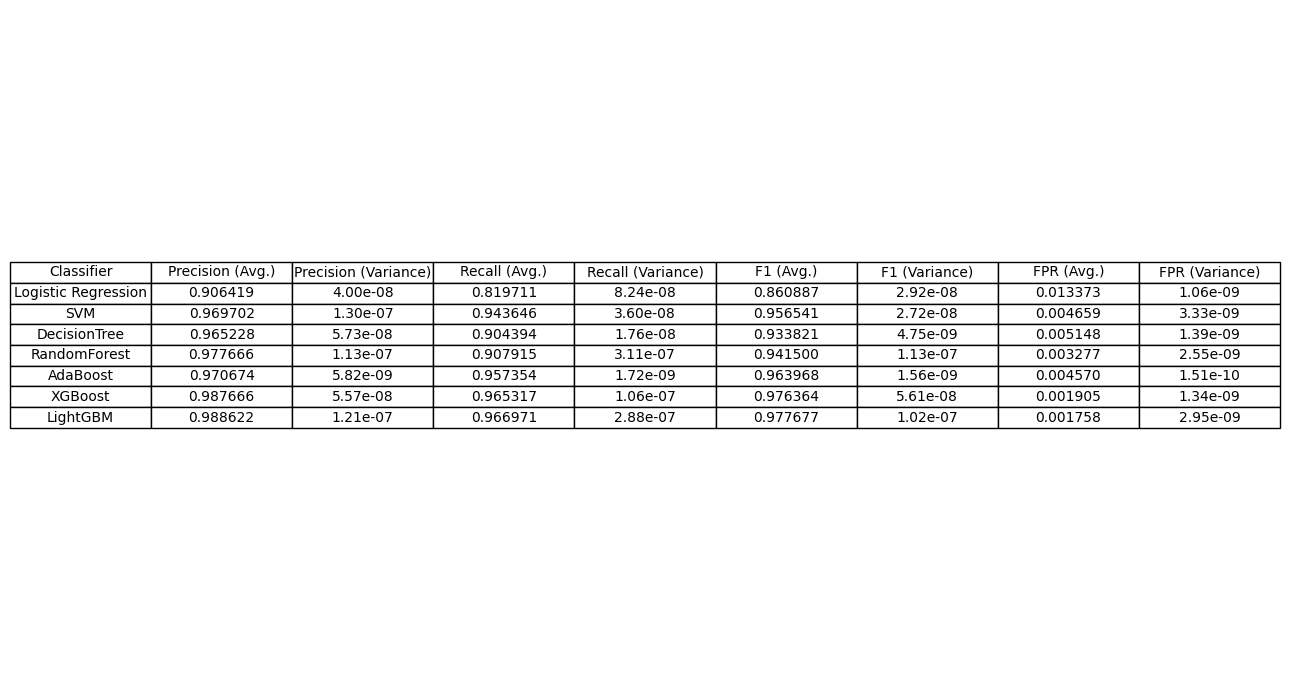

'table_with_variances.png'

In [34]:
import numpy as np2
import matplotlib.pyplot as plt

def calculate_averages_and_variances(results):
    stats = {}
    for classifier, metrics in results.items():
        stats[classifier] = {}
        for metric, values in metrics.items():
            avg = np.mean(values)
            var = np.var(values, ddof=1)  # Unbiased estimator, using sample variance
            stats[classifier][metric] = {'average': avg, 'variance': var}
    return stats

def draw_table_with_variances(stats):
    # Define the metrics
    metrics = ['Precision', 'Recall', 'F1', 'FPR']
    # Create headers for the table: 'Metric (Avg.)' followed by 'Metric (Variance)'
    headers = ['Classifier']
    for metric in metrics:
        headers.extend([f'{metric} (Avg.)', f'{metric} (Variance)'])
    
    # Create the table data structure
    cell_text = [headers]
    
    # Fill in the data rows
    for classifier, metrics_data in stats.items():
        row = [classifier]
        for metric in metrics:
            avg = metrics_data[metric]['average']
            var = metrics_data[metric]['variance']
            row.extend([f"{avg:.6f}", f"{var:.2e}"])
        cell_text.append(row)

    # Determine the figure width dynamically: base_width + (num_columns * width_per_column)
    num_columns = len(headers)
    width_per_column = 1.0  # starting point for width per column, may need adjustment
    base_width = 4  # base width to account for the first column which typically needs more space
    fig_width = base_width + (num_columns * width_per_column)

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(fig_width, 2 + 0.625 * len(cell_text)))  # Adjust the size as needed
    ax.axis('off')  # Hide the axes

    # Create the table and adjust the layout
    table = ax.table(cellText=cell_text, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)

    plt.tight_layout()
    return fig

# Calculate averages and variances
stats = calculate_averages_and_variances(results)

# Draw the table with variances
fig = draw_table_with_variances(stats)

# Save the figure to a file and show it
output_file = "table_with_variances.png"
fig.savefig(output_file)
plt.show()

# Return the path to the saved figure
output_file


## Shorthands for classifier names

In [35]:
shorthands = {
    'Logistic Regression': 'LR',
    'DecisionTree': 'DT',
    'RandomForest': 'RF',
    'SVM': 'SVM',
    'AdaBoost': 'ADAB',
    'XGBoost': 'XGB',
    'LightGBM': 'LGBM',
}

## Generate LaTeX tabular code

In [36]:
def generate_latex_tabular(stats):
    # Define the metrics
    metrics = ['Precision', 'Recall', 'F1', 'FPR']
    
    # Find the highest average for each metric except for FPR, where we find the lowest
    highest_avg = {metric: max(metrics_data[metric]['average'] for metrics_data in stats.values()) for metric in metrics if metric != 'FPR'}
    lowest_fpr = min(stats[classifier]['FPR']['average'] for classifier in stats)
    
    # Initialize the LaTeX table string
    latex_table = "\\begin{tabular}{|l|" + "c|c|" * len(metrics) + "}\n\\hline\n"
    
    # Create the header row with multicolumns for average and variance
    latex_table += " & " + " & ".join([f"\\multicolumn{{2}}{{c|}}{{\\textbf{{{metric}}}}}" for metric in metrics]) + " \\\\\n"
    latex_table += "\\hline\n"
    latex_table += "\\textbf{Classifier} & " + " & ".join(["Avg. & Variance" for _ in metrics]) + " \\\\\n\\hline\n"
    
    # Fill in the data rows
    for classifier, metrics_data in stats.items():
        cln = classifier
        shorthand = shorthands[classifier]
        if shorthand != classifier:
            cln = f"{classifier} ({shorthand})"
        row = [cln.replace('_', '\\_')]  # Escape underscores for LaTeX
        for metric in metrics:
            avg = metrics_data[metric]['average']
            # Bold the highest average or the lowest FPR
            if metric == 'FPR':
                avg_str = f"\\textbf{{{avg:.6f}}}" if avg == lowest_fpr else f"{avg:.6f}"
            else:
                avg_str = f"\\textbf{{{avg:.6f}}}" if avg == highest_avg.get(metric, None) else f"{avg:.6f}"
            var = metrics_data[metric]['variance']
            # Display variance in scientific notation
            var_str = "{:.2e}".format(var) if var > 0 else "0.00e+00"
            row.extend([avg_str, var_str])
        latex_table += " & ".join(row) + " \\\\\n\\hline\n"
    
    # Close the LaTeX table string
    latex_table += "\\end{tabular}"
    
    return latex_table

# Calculate averages and variances
stats = calculate_averages_and_variances(results)

# Generate LaTeX tabular code for the table
latex_tabular_code = generate_latex_tabular(stats)
print(latex_tabular_code)

# Save the LaTeX code to a file
output_file = "table_with_variances.tex"
with open(output_file, "w") as f:
    f.write(latex_tabular_code)

# Return the path to the saved LaTeX file
output_file


\begin{tabular}{|l|c|c|c|c|c|c|c|c|}
\hline
 & \multicolumn{2}{c|}{\textbf{Precision}} & \multicolumn{2}{c|}{\textbf{Recall}} & \multicolumn{2}{c|}{\textbf{F1}} & \multicolumn{2}{c|}{\textbf{FPR}} \\
\hline
\textbf{Classifier} & Avg. & Variance & Avg. & Variance & Avg. & Variance & Avg. & Variance \\
\hline
Logistic Regression (LR) & 0.906419 & 4.00e-08 & 0.819711 & 8.24e-08 & 0.860887 & 2.92e-08 & 0.013373 & 1.06e-09 \\
\hline
SVM & 0.969702 & 1.30e-07 & 0.943646 & 3.60e-08 & 0.956541 & 2.72e-08 & 0.004659 & 3.33e-09 \\
\hline
DecisionTree (DT) & 0.965228 & 5.73e-08 & 0.904394 & 1.76e-08 & 0.933821 & 4.75e-09 & 0.005148 & 1.39e-09 \\
\hline
RandomForest (RF) & 0.977666 & 1.13e-07 & 0.907915 & 3.11e-07 & 0.941500 & 1.13e-07 & 0.003277 & 2.55e-09 \\
\hline
AdaBoost (ADAB) & 0.970674 & 5.82e-09 & 0.957354 & 1.72e-09 & 0.963968 & 1.56e-09 & 0.004570 & 1.51e-10 \\
\hline
XGBoost (XGB) & 0.987666 & 5.57e-08 & 0.965317 & 1.06e-07 & 0.976364 & 5.61e-08 & 0.001905 & 1.34e-09 \\
\hline
LightGBM

'table_with_variances.tex'

## Boxplots for boosted trees only

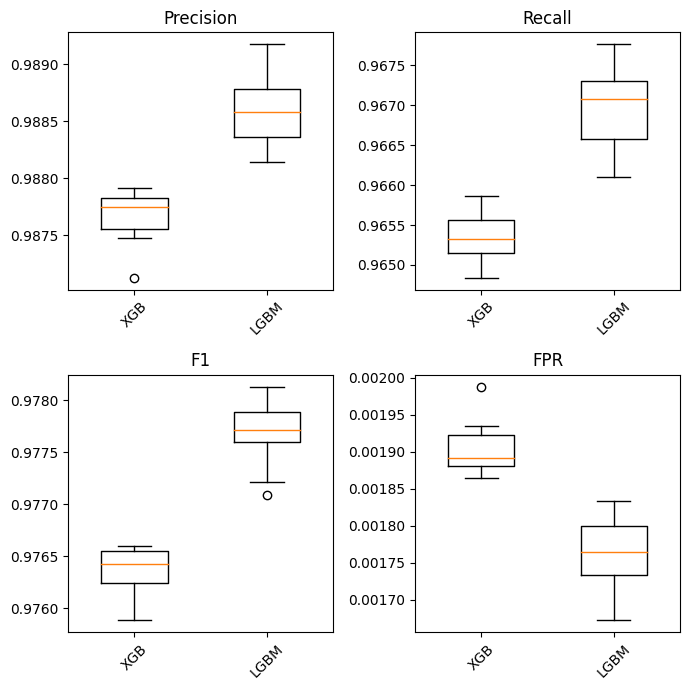

In [43]:
import copy

#boosted_trees = ["AdaBoost", "XGBoost", "LightGBM"]
boosted_trees = ["XGBoost", "LightGBM"]
results_filtered = {shorthands[classifier]: results[classifier] for classifier in boosted_trees if classifier in results}

import numpy as np
import matplotlib.pyplot as plt

# Function to adjust the y-axis limits
def get_ylim(data_list):
    data_min = np.min(data_list)
    data_max = np.max(data_list)
    
    # Inflate the range slightly to make sure all data points are comfortably within the plot
    padding = (data_max - data_min) * 0.05
    lower = data_min - padding
    upper = data_max + padding
    
    # Ensure that the lower limit is not less than 0 since these metrics cannot be negative
    lower = max(lower, 0)
    return (lower, upper)


# Adjust the plotting function to display results for all classifiers
def plot_metric(metric, results, ax):
    data = [results[classifier][metric] for classifier in results]
    ax.boxplot(data, positions=range(1, len(results)+1), widths=0.5)
    ax.set_title(metric)
    # Set x-axis labels to classifier names
    ax.set_xticks(range(1, len(results)+1))
    ax.set_xticklabels(results.keys(), rotation=45)
    
    # Set y-axis limits
    all_data = [item for sublist in data for item in sublist]  # Flatten the list
    ax.set_ylim(*get_ylim(all_data))

    
# Display boxplots for each metric for all classifiers
fig, axs = plt.subplots(2, 2, figsize=(7, 7))
metrics = ['Precision', 'Recall', 'F1', 'FPR']
for i, metric in enumerate(metrics):
    plot_metric(metric, results_filtered, axs[i//2, i%2])

plt.tight_layout()
plt.savefig("classifier_comparison_boosted.png")
plt.savefig("classifier_comparison_boosted.pdf", format="pdf")
plt.show()

## Boxplots for all classifiers

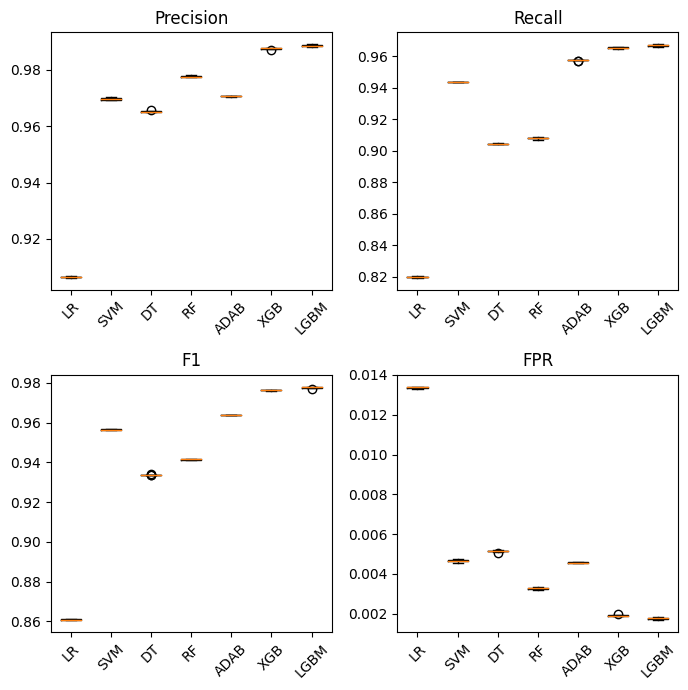

In [42]:
import numpy as np
import matplotlib.pyplot as plt

results_display = {shorthands[classifier]: results[classifier] for classifier in results}

# Function to adjust the y-axis limits
def get_ylim(data_list):
    data_min = np.min(data_list)
    data_max = np.max(data_list)
    
    # Inflate the range slightly to make sure all data points are comfortably within the plot
    padding = (data_max - data_min) * 0.05
    lower = data_min - padding
    upper = data_max + padding
    
    # Ensure that the lower limit is not less than 0 since these metrics cannot be negative
    lower = max(lower, 0)
    return (lower, upper)


# Adjust the plotting function to display results for all classifiers
def plot_metric(metric, results_display, ax):
    data = [results_display[classifier][metric] for classifier in results_display]
    ax.boxplot(data, positions=range(1, len(results_display)+1), widths=0.5)
    ax.set_title(metric)
    # Set x-axis labels to classifier names
    ax.set_xticks(range(1, len(results_display)+1))
    ax.set_xticklabels(results_display.keys(), rotation=45)
    
    # Set y-axis limits
    all_data = [item for sublist in data for item in sublist]  # Flatten the list
    ax.set_ylim(*get_ylim(all_data))
    
    
# Display boxplots for each metric for all classifiers
fig, axs = plt.subplots(2, 2, figsize=(7, 7))
metrics = ['Precision', 'Recall', 'F1', 'FPR']
for i, metric in enumerate(metrics):
    plot_metric(metric, results_display, axs[i//2, i%2])

plt.tight_layout()
plt.savefig("classifier_comparison_all.png")
plt.savefig("classifier_comparison_all.pdf", format="pdf")

plt.show()

## Saved results

### 20% of the dataset, 2 runs each
{'Logistic Regression': {'Accuracy': [0.9643332446100612, 0.964399787064147],
  'Precision': [0.9070018924033523, 0.9077131258457375],
  'Recall': [0.8216997305902523, 0.8214548126377663],
  'F1': [0.8622462092007196, 0.8624325019285163],
  'FPR': [0.013244523158664766, 0.01312901859623455]},
 'DecisionTree': {'Accuracy': [0.9767766835240884, 0.9768099547511312],
  'Precision': [0.9338631120225583, 0.9349948612538541],
  'Recall': [0.8922361009061964, 0.8912564290962528],
  'F1': [0.9125751503006012, 0.9126018808777431],
  'FPR': [0.009933392368998576, 0.009740884764948216]},
 'RandomForest': {'Accuracy': [0.9792387543252595, 0.979138940644131],
  'Precision': [0.931189229618549, 0.9315684315684316],
  'Recall': [0.9147685525349009, 0.9135439627724712],
  'F1': [0.9229058561897703, 0.9224681587733399],
  'FPR': [0.010626419743579871, 0.010549416701959727]},
 'SVM': {'Accuracy': [0.9833643864785734, 0.9831980303433591],
  'Precision': [0.9538890296427667, 0.9536004056795132],
  'Recall': [0.9221160911094783, 0.9211364192995346],
  'F1': [0.937733499377335, 0.9370873302603713],
  'FPR': [0.007007276787433104, 0.007045778308243176]},
 'AdaBoost': {'Accuracy': [0.9860593558690445, 0.985926270960873],
  'Precision': [0.9557213930348258, 0.9545454545454546],
  'Recall': [0.940974773450894, 0.9412196914033799],
  'F1': [0.9482907565099346, 0.9478357380688125],
  'FPR': [0.006853270704192816, 0.007045778308243176]},
 'XGBoost': {'Accuracy': [0.989353207346287, 0.9896526483896726],
  'Precision': [0.9820650781450166, 0.9818599897802759],
  'Recall': [0.9387705118785207, 0.9412196914033799],
  'F1': [0.9599298772852491, 0.9611104164061524],
  'FPR': [0.0026951064567050397, 0.0027336079775151117]},
 'LightGBM': {'Accuracy': [0.9904178866116582, 0.9906507852009582],
  'Precision': [0.9822109275730623, 0.9834689725330621],
  'Recall': [0.94660788635807, 0.9470977222630419],
  'F1': [0.9640808181591419, 0.9649407361197755],
  'FPR': [0.0026951064567050397, 0.00250259885265468]}}

### 20% of the dataset, 5 runs each
{'Logistic Regression': {'Accuracy': [0.9642928439292511,
   0.9642928439292511,
   0.9643460786009929,
   0.964226300589574,
   0.9642396092575094],
  'Precision': [0.9002855028021571,
   0.9005396254364617,
   0.9008360673087099,
   0.9002327549724926,
   0.9001586462189318],
  'Recall': [0.8303101228788765,
   0.8300175541252194,
   0.8301150770431052,
   0.829822508289448,
   0.8300175541252194],
  'F1': [0.8638831109532747,
   0.8638416645521441,
   0.8640308582449373,
   0.8635948442098853,
   0.8636663453244711],
  'FPR': [0.014533405255451954,
   0.014487169607767589,
   0.014440933960083224,
   0.014533405255451954,
   0.014548817138013408]},
 'SVM': {'Accuracy': [0.9867046407325091,
   0.9866780233966382,
   0.9865848627210902,
   0.9867179494004445,
   0.9866114800569611],
  'Precision': [0.9637238200220463,
   0.9633450175262894,
   0.9628554265118142,
   0.9640064166833768,
   0.9635124298315958],
  'Recall': [0.9378779013068071,
   0.9380729471425785,
   0.9378779013068071,
   0.9376828554710357,
   0.9373902867173786],
  'F1': [0.9506252162309099,
   0.9505410346360987,
   0.9502025491552218,
   0.9506624480917539,
   0.9502718734552645],
  'FPR': [0.005579101487246667,
   0.005640749017492487,
   0.0057178084302997615,
   0.005532865839562302,
   0.005609925252369577]},
 'DecisionTree': {'Accuracy': [0.9815275689056282,
   0.9815142602376928,
   0.9815674949094345,
   0.9814210995621448,
   0.9815941122453054],
  'Precision': [0.9568219291014015,
   0.9564411492122336,
   0.9569294178258629,
   0.9565038136466708,
   0.957032457496136],
  'Recall': [0.9055002925687536,
   0.9057928613224108,
   0.9056953384045251,
   0.9050126779793252,
   0.9057928613224108],
  'F1': [0.930453953301934,
   0.930428249436514,
   0.9306077458790522,
   0.9300461014231309,
   0.9307079513001654],
  'FPR': [0.006457578793249596,
   0.006519226323495415,
   0.00644216691068814,
   0.0065038144409339605,
   0.006426755028126686]},
 'RandomForest': {'Accuracy': [0.981394482226274,
   0.9813412475545322,
   0.9815408775735637,
   0.9812480868789842,
   0.9814210995621448],
  'Precision': [0.9694656488549618,
   0.9690546841882154,
   0.9698993110757816,
   0.9700286959294293,
   0.9697708952057701],
  'Recall': [0.8917495611468695,
   0.8917495611468695,
   0.8924322215720695,
   0.8900916715428125,
   0.8916520382289838],
  'F1': [0.9289850655288022,
   0.928796343321483,
   0.9295545736197877,
   0.9283425723439964,
   0.9290722487552078],
  'FPR': [0.004438622177699006,
   0.0045002697079448255,
   0.004376974647453186,
   0.0043461508823302766,
   0.004392386530014641]},
 'AdaBoost': {'Accuracy': [0.9887142495907585, 0.9887142495907585],
  'Precision': [0.9682397451214656, 0.9682397451214656],
  'Recall': [0.948410376438463, 0.948410376438463],
  'F1': [0.9582224849738891, 0.9582224849738891],
  'FPR': [0.004916390537104107, 0.004916390537104107]},
 'XGBoost': {'Accuracy': [0.9919482558990671,
   0.9920014905708088,
   0.9921878119219047,
   0.9920680339104859,
   0.9922410465936464],
  'Precision': [0.9830780014018223,
   0.9835687806832982,
   0.9844642678159767,
   0.9838677354709419,
   0.9852483692925238],
  'Recall': [0.9574800078018334,
   0.9573824848839477,
   0.9578700994733762,
   0.9575775307197192,
   0.9574800078018334],
  'F1': [0.970110172422311,
   0.9702989869038794,
   0.9709851218427166,
   0.970544627854107,
   0.9711657351995646],
  'FPR': [0.002604608152885875,
   0.0025275487400786005,
   0.002388841797025507,
   0.002481313092394236,
   0.0022655467365338675]},
 'LightGBM': {'Accuracy': [0.9927334673072572,
   0.9926935413034509,
   0.99266692396758,
   0.9926403066317092,
   0.9925471459561612],
  'Precision': [0.9857886309047238,
   0.9856871184065659,
   0.9862684173599279,
   0.985681385801542,
   0.9858660785886126],
  'Recall': [0.9606007411741759,
   0.9604056953384045,
   0.9596255119953189,
   0.9600156036668617,
   0.9591378974058904],
  'F1': [0.9730317099674011,
   0.9728821931341072,
   0.9727645692254461,
   0.972679215453782,
   0.9723183391003459],
  'FPR': [0.002188487323726593,
   0.002203899206288048,
   0.0021114279109193186,
   0.002203899206288048,
   0.0021730754411651383]}}